# Import files

In [1]:
from Strats.MeanReversionStrat import *
from Strats.RegressionStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

## Mean-Reversion

In [2]:
# test_pairs = coint_pairs[:4]
test_cons = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
print(test_cons)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_cons:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
portfolio_prices = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-07-01",
        end_date="2025-05-31"
    )

portfolio_prices

['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
'BTCUSDT' added successfully.
'ETHUSDT' added successfully.
'BNBUSDT' added successfully.


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT
0,2024-07-01 00:00:00,582.00,62722.08,3437.02
1,2024-07-01 00:05:00,580.60,62648.49,3433.81
2,2024-07-01 00:10:00,580.40,62624.00,3435.74
3,2024-07-01 00:15:00,581.00,62682.02,3438.27
4,2024-07-01 00:20:00,581.30,62674.01,3438.29
...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34


In [3]:
model = MeanReversionStrat(portfolio_prices.copy(), test_cons)
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=1)
spread

100%|██████████| 87553/87553 [00:09<00:00, 9206.80it/s] 


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT,BTCUSDT_rolling_mean,BTCUSDT_rolling_std,BTCUSDT_z_scores,BTCUSDT_is_mean_revert,BTCUSDT_signal,BTCUSDT_exit_signal,...,ETHUSDT_z_scores,ETHUSDT_is_mean_revert,ETHUSDT_signal,ETHUSDT_exit_signal,BNBUSDT_rolling_mean,BNBUSDT_rolling_std,BNBUSDT_z_scores,BNBUSDT_is_mean_revert,BNBUSDT_signal,BNBUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,3437.02,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
1,2024-07-01 00:05:00,580.60,62648.49,3433.81,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
2,2024-07-01 00:10:00,580.40,62624.00,3435.74,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
3,2024-07-01 00:15:00,581.00,62682.02,3438.27,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
4,2024-07-01 00:20:00,581.30,62674.01,3438.29,NaN,NaN,NaN,0,0,0,...,NaN,0,0,0,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88,103324.454249,4913.583066,0.097262,0,0,1,...,0.503339,0,0,1,645.190730,30.345220,0.327540,0,0,1
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38,103325.592630,4912.615493,0.151000,0,0,1,...,0.529514,0,0,1,645.197262,30.341492,0.359005,0,0,1
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39,103326.726086,4911.643422,0.139205,0,0,1,...,0.532468,0,0,1,645.203773,30.337729,0.349276,0,0,1
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34,103327.861905,4910.660730,0.133916,0,0,1,...,0.541439,0,0,1,645.210194,30.334006,0.334602,0,0,1


In [4]:
test_start_date, test_end_date = "2024-10-01", "2025-05-31"

In [5]:
stoploss = 10e6
drawdown_duration = 10e6
rolling=2000
weight_method=hierarchical_risk_parity_weighting
short = False

mr_backtest = Backtest(spread.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
mr_pnl_df = mr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
mr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.0,0.000000e+00
1,2024-10-01 00:05:00,0.0,0.000000e+00
2,2024-10-01 00:10:00,0.0,0.000000e+00
3,2024-10-01 00:15:00,0.0,0.000000e+00
4,2024-10-01 00:20:00,0.0,0.000000e+00
...,...,...,...
69692,2025-05-30 23:40:00,0.0,4.917702e+06
69693,2025-05-30 23:45:00,0.0,4.917702e+06
69694,2025-05-30 23:50:00,0.0,4.917702e+06
69695,2025-05-30 23:55:00,0.0,4.917702e+06


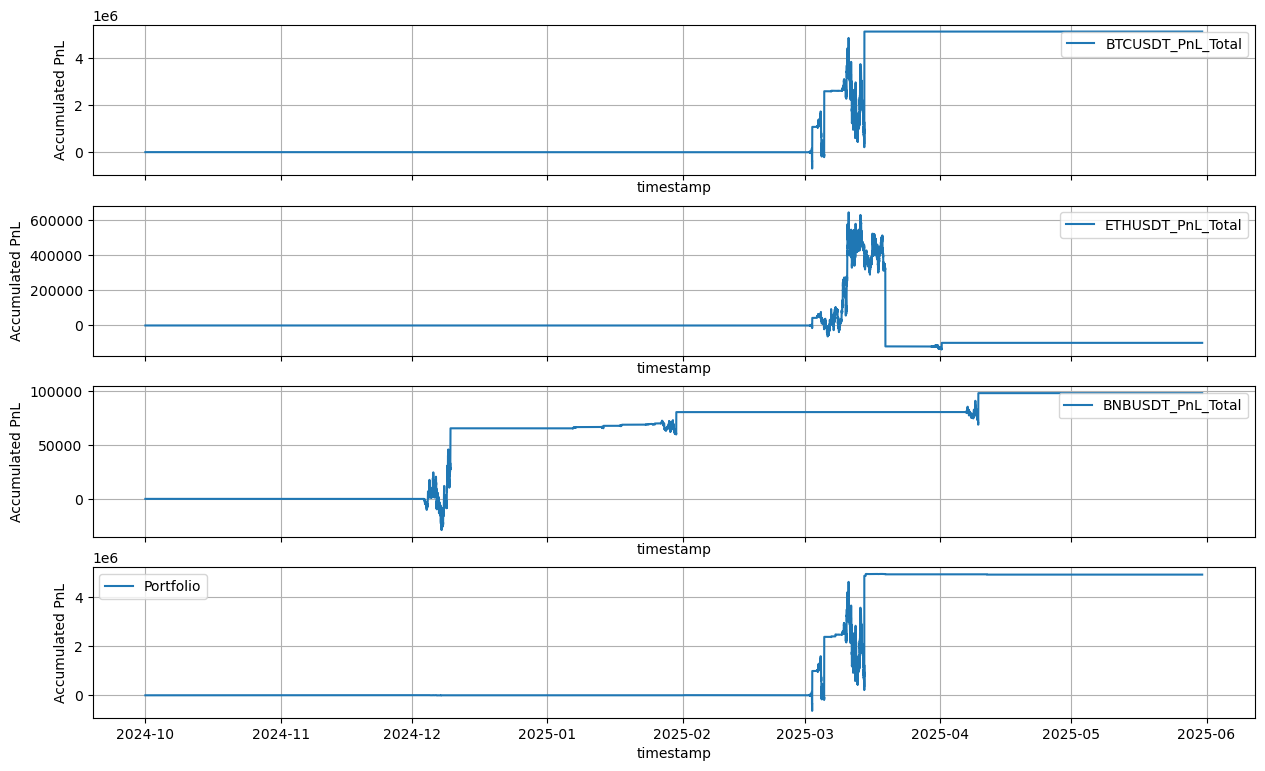

In [6]:
mr_backtest.plot_pnl(mr_pnl_df)

## Simple Momentum

In [7]:
simple_strat = SimpleStrat(data=portfolio_prices)
simple_df = simple_strat.simple_strategy(lookback=12*24*3, hold_period=12*24*3)

In [8]:
simple_backtest = Backtest(simple_df.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
simple_pnl_df = simple_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
simple_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.000000,0.000000
1,2024-10-01 00:05:00,0.000000,0.000000
2,2024-10-01 00:10:00,0.000000,0.000000
3,2024-10-01 00:15:00,0.000000,0.000000
4,2024-10-01 00:20:00,0.000000,0.000000
...,...,...,...
69692,2025-05-30 23:40:00,32.929295,17226.678178
69693,2025-05-30 23:45:00,30.489450,17224.238333
69694,2025-05-30 23:50:00,30.199539,17223.948422
69695,2025-05-30 23:55:00,29.352770,17223.101652


In [20]:
r = simple_pnl_df['total_pnl'].diff()/10e6
r.mean()/r.std() * np.sqrt(252*12*24)

0.45430095537956044

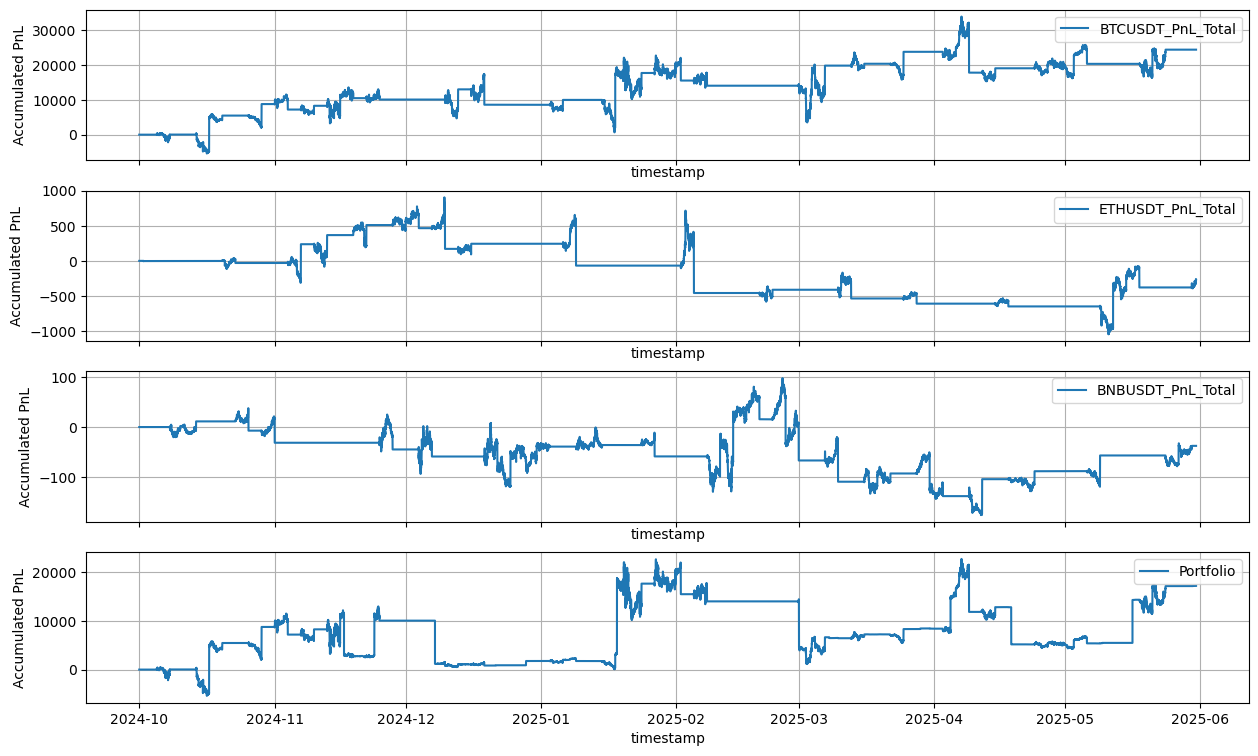

In [9]:
simple_backtest.plot_pnl(simple_pnl_df)

## Regression


In [28]:
lr_model = RegressionStrat(portfolio_prices.copy(), test_cons, lookback_window=8000, regression_type='theilsen')
lr_signals = lr_model.generate_signals(pca_components=3, threshold=0)
lr_signals

100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


,timestamp,BNBUSDT,BTCUSDT,ETHUSDT,BTCUSDT_pred,BTCUSDT_is_trend,BTCUSDT_signal,BTCUSDT_exit_signal,ETHUSDT_pred,ETHUSDT_is_trend,ETHUSDT_signal,ETHUSDT_exit_signal,BNBUSDT_pred,BNBUSDT_is_trend,BNBUSDT_signal,BNBUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,3437.02,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
1,2024-07-01 00:05:00,580.60,62648.49,3433.81,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
2,2024-07-01 00:10:00,580.40,62624.00,3435.74,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
3,2024-07-01 00:15:00,581.00,62682.02,3438.27,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
4,2024-07-01 00:20:00,581.30,62674.01,3438.29,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96188,2025-05-30 23:40:00,655.13,103802.36,2518.88,-0.000209,1,-1,0,0.000357,1,1,0,0.000085,1,1,0
96189,2025-05-30 23:45:00,656.09,104067.40,2527.38,-0.000185,1,-1,0,0.000108,1,1,0,0.000129,1,1,0
96190,2025-05-30 23:50:00,655.80,104010.45,2528.39,-0.000317,1,-1,0,-0.000073,1,-1,0,0.000053,1,1,0
96191,2025-05-30 23:55:00,655.36,103985.48,2531.34,-0.000234,1,-1,0,0.000147,1,1,0,0.000166,1,1,0


In [29]:
lr_backtest = Backtest(lr_signals.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
lr_pnl_df = lr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
lr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-10-01 00:00:00,0.000000,0.000000
1,2024-10-01 00:05:00,3.892535,3.892535
2,2024-10-01 00:10:00,0.000000,3.892535
3,2024-10-01 00:15:00,-106.329169,-102.436634
4,2024-10-01 00:20:00,0.000000,-102.436634
...,...,...,...
69692,2025-05-30 23:40:00,1184.813223,38085.398556
69693,2025-05-30 23:45:00,-405.321047,36495.264286
69694,2025-05-30 23:50:00,-6.697745,36893.887588
69695,2025-05-30 23:55:00,193.047573,37093.633255


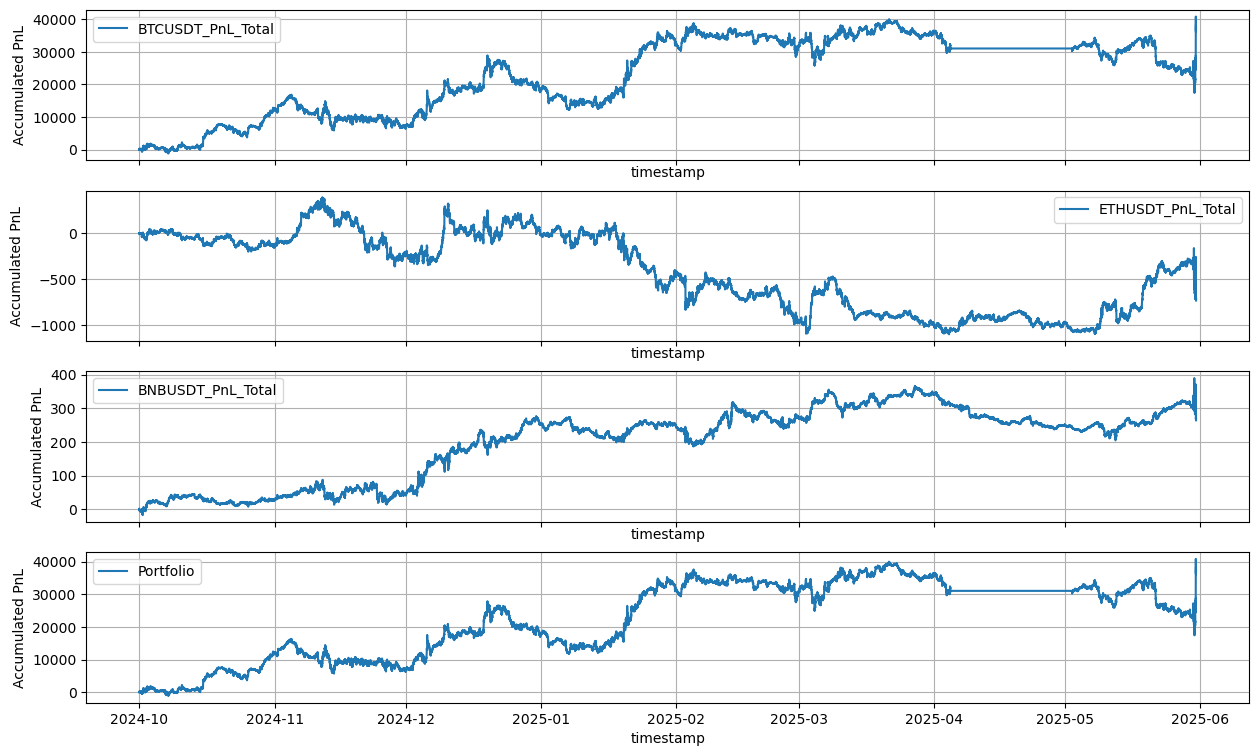

In [30]:
lr_backtest.plot_pnl(lr_pnl_df)

# Comparison

In [26]:
mr_returns = mr_backtest.get_returns(mr_pnl_df, notional = 10e6)
momentum_returns = simple_backtest.get_returns(simple_pnl_df, notional = 10e6)
lr_returns = lr_backtest.get_returns(lr_pnl_df, notional = 10e6)

returns = pd.DataFrame(list(zip(momentum_returns, mr_returns, lr_returns)), columns=['Simple', 'MeanRevert', 'Regression'])
port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Simple               0.001179               0.003988      0.297434   
MeanRevert           0.505191               0.803908      0.856744   
Regression           0.000585               0.001851      0.316786   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio    Skewness  \
Simple                      32809     -0.002154      0.547377   18.559237   
MeanRevert                  32809     -0.394156      1.281703   88.418167   
Regression                  32809     -0.001127      0.518784  131.195544   

                Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Simple       3718.089408 -0.000005  -0.000016    0.967485     1.012474  
MeanRevert  12678.287359 -0.000005  -0.002517    0.967485     1.079007  
Regression  24074.669852 -0.000005  -0.000011    0.967485     1.014596  


In [27]:
wrc = WhiteRealityCheck(strategies=returns["MeanRevert"], benchmark=returns["Simple"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.141
consistent    0.141
upper         0.141
dtype: float64
Superior strategy indices:
[]


[]